In [1]:
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cv2

import open3d as o3d

import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Read in sample images
folder_path = Path("./")

num_samples = 1
selection = random.sample(os.listdir(folder_path), num_samples)

selected_images = []
for i in range(num_samples):    
    pathi = str(folder_path / selection[i])
    selected_image = cv2.imread(pathi)
    selected_image = cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB)
    selected_images.append(selected_image)

exporting = True

In [3]:
checkpoints = [
    "Intel/zoedepth-nyu-kitti",
    "LiheYoung/depth-anything-large-hf",
    "jingheya/lotus-depth-g-v1-0",   
    "tencent/DepthCrafter"
    ]

checkpoint = checkpoints[1]

# take care of the necessary image transformations such as resizing and normalization
processor = AutoImageProcessor.from_pretrained(checkpoints[1])
model = AutoModelForDepthEstimation.from_pretrained(checkpoints[1]).to("cuda")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
depth_samples = []
for i in range(num_samples):
    depth_input = processor(images=selected_images[i], return_tensors="pt").to("cuda")

    # Infer model
    with torch.no_grad():
        inference_outputs = model(**depth_input)
        output_depth = inference_outputs.predicted_depth
    
    output_depth = output_depth.squeeze().cpu().numpy()
    
    depth_samples.append([selected_images[i], output_depth])

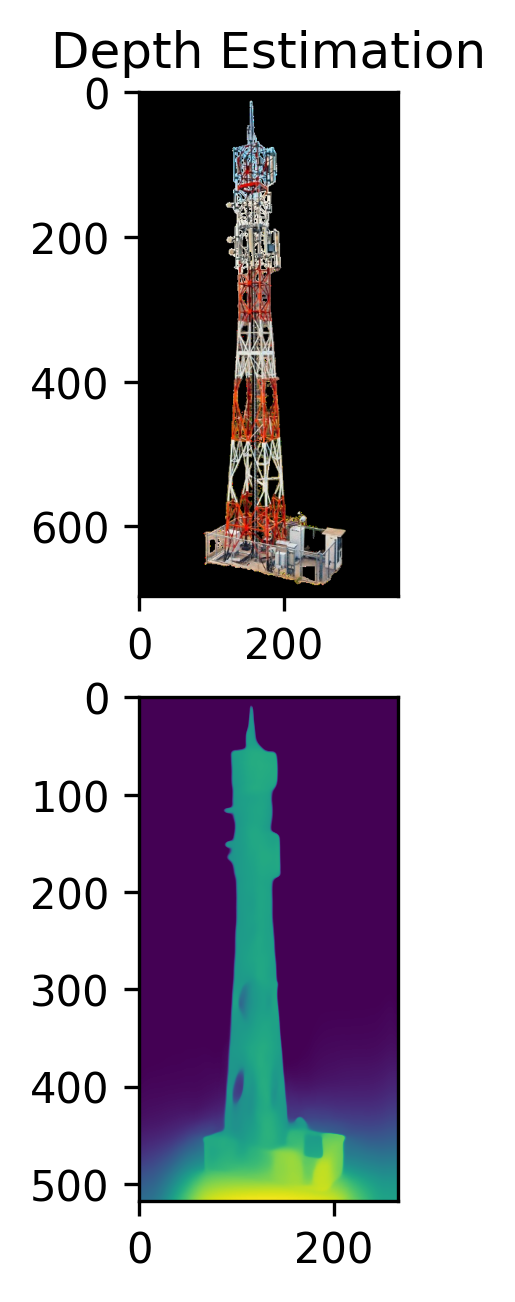

In [5]:
plt.rcParams['figure.dpi'] = 300

for i in range(num_samples):
    fig, axs = plt.subplots(2, 1)
    
    axs[0].imshow(depth_samples[i][0])
    axs[0].set_title('Depth Estimation')
    axs[1].imshow(depth_samples[i][1])
    
    plt.show()

In [6]:
for i in range(num_samples):
    depth_image = depth_samples[i][1]
    color_image = depth_samples[i][0]
    width, height = depth_image.shape

    depth_image = (depth_image * 255 / np.max(depth_image)).astype('uint8')
    color_image = cv2.resize(color_image, (height, width))
    
    cv2.imwrite('./'+str(i)+'.png', cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
    cv2.imwrite('./'+str(i)+'_depth.png', depth_image)

In [7]:
i = 0

depth_image = depth_samples[i][1]
color_image = depth_samples[i][0]
width, height = depth_image.shape

depth_image = (depth_image * 255 / np.max(depth_image)).astype('uint8')
color_image = cv2.resize(color_image, (height, width))

PCD:Orthographic Projection

In [20]:
def depth_to_pointcloud_orthographic(depth_map, image, scale_factor=1000):
    height, width = depth_map.shape

    # Create a grid of pixel coordinates
    y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

    # Scale the depth values
    z = (depth_map / scale_factor) * height/2

    # Create 3D points (x and y are pixel coordinates, z is from the depth map)
    points = np.stack((x, y, z), axis=-1).reshape(-1, 3)

    # Filter out points with zero depth
    mask = points[:, 2] != 0
    points = points[mask]

    # Create Open3D PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pcd])
    
    # Add colors to the point cloud
    colors = image.reshape(-1, 3)[mask] / 255.0  # Normalize color values to [0, 1]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    _, ind = pcd.remove_statistical_outlier(nb_neighbors=15, std_ratio=1)
    inlier_cloud = pcd.select_by_index(ind)

    return inlier_cloud, z, height, width 

In [21]:
# Convert depth map and image to point cloud
point_cloud, z, height, width  = depth_to_pointcloud_orthographic(depth_image, color_image)

o3d.visualization.draw_geometries([point_cloud])

In [22]:
# outliers removal
cl, ind = point_cloud.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.0)
point_cloud = point_cloud.select_by_index(ind)

In [23]:
# estimate normals
point_cloud.estimate_normals()
point_cloud.orient_normals_to_align_with_direction()
o3d.visualization.draw_geometries([point_cloud])

In [12]:
o3d.io.write_point_cloud("./output_point_cloud.xyz", point_cloud, write_ascii=True)

True

In [24]:
point_cloud.estimate_normals()
point_cloud.orient_normals_to_align_with_direction()

print('run Poisson surface reconstruction')
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=11)
o3d.visualization.draw_geometries([mesh])

run Poisson surface reconstruction


In [25]:
o3d.io.write_triangle_mesh('./mesh_ortho.obj', mesh, write_triangle_uvs = True)

True